# PLD-detrended light curve analysis (248662696)

* 9/27: created

TODO:
* add MCMC

In [1]:
!python --version

Python 2.7.13 :: Continuum Analytics, Inc.


In [2]:
import numpy as np
import os
os.environ['CONDA_DEFAULT_ENV']

'K2phot'

In [3]:
data=np.loadtxt('detrended_flux_PLD_248662696.txt',comments='#')
data.shape

(3855, 6)

In [4]:
# time,aperture sum,least squares,order1,order2,order3

t=data[:,0]
raw=data[:,1]
f_ls=data[:,2]
f_o3=data[:,3]

raw

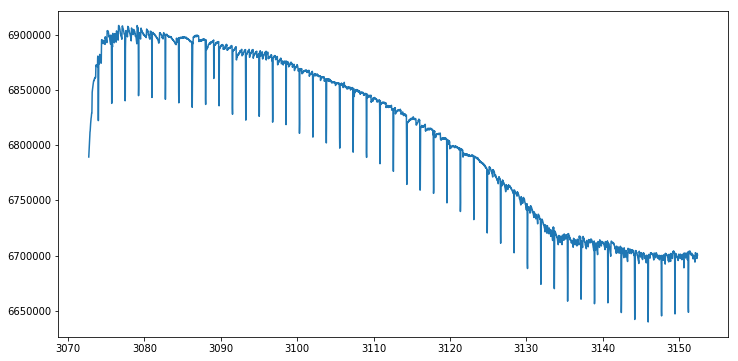

In [5]:
import matplotlib.pyplot as pl
%matplotlib inline

fig,ax=pl.subplots(1,1,figsize=(12,6))
ax.plot(t, raw)

least-squares model

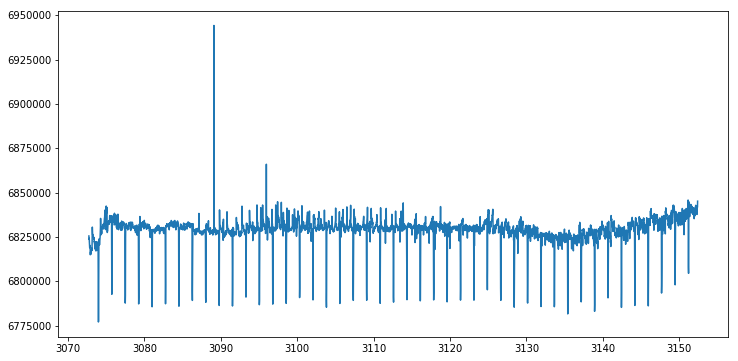

In [6]:
fig,ax=pl.subplots(1,1,figsize=(12,6))
ax.plot(t, f_ls)

3rd order PLD

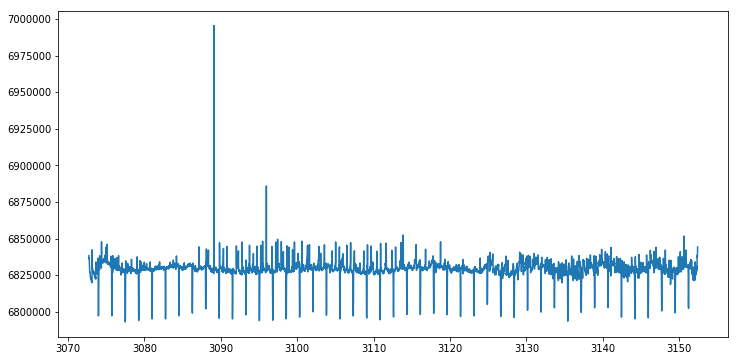

In [7]:
fig,ax=pl.subplots(1,1,figsize=(12,6))
ax.plot(t, f_o3)

In [8]:
t=data[:,0]
f=f_o3
cut = np.where(f > 6875000)
t = np.delete(t, cut)
f = np.delete(f_o3, cut)

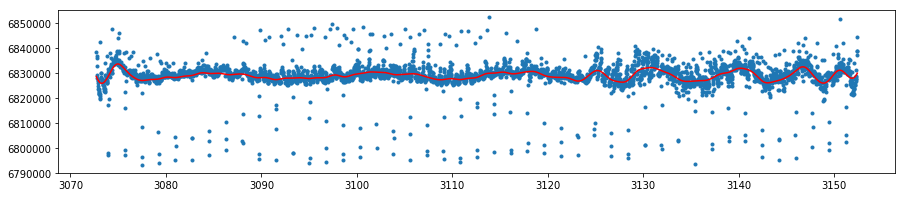

In [9]:
#fit spline

from scipy.interpolate import Rbf
rbfi = Rbf(t, f, function='quintic', smooth=100)

fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(t, f, '.')
ax.plot(t, rbfi(t), 'r-')

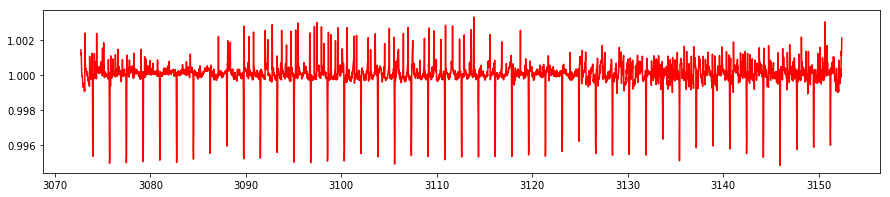

In [10]:
fig, ax = pl.subplots(1,1,figsize=(15,3))
f_d=f/rbfi(t)
ax.plot(t, f_d, 'r-')

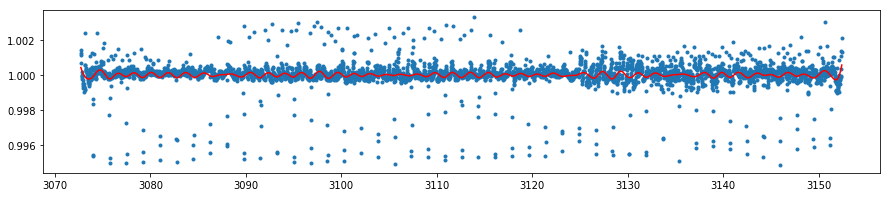

In [11]:
from scipy.interpolate import Rbf
rbfi = Rbf(t, f_d, function='quintic', smooth=10)

fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(t, f_d, '.')
ax.plot(t, rbfi(t), 'r-')

In [12]:
from gatspy.periodic import LombScargleFast

model = LombScargleFast().fit(t, f_d)
periods, power = model.periodogram_auto(nyquist_factor=100)

In [13]:
periods[periods > 1][np.argmax(power[periods > 1])]

1.7553095726833763

1.75530957268


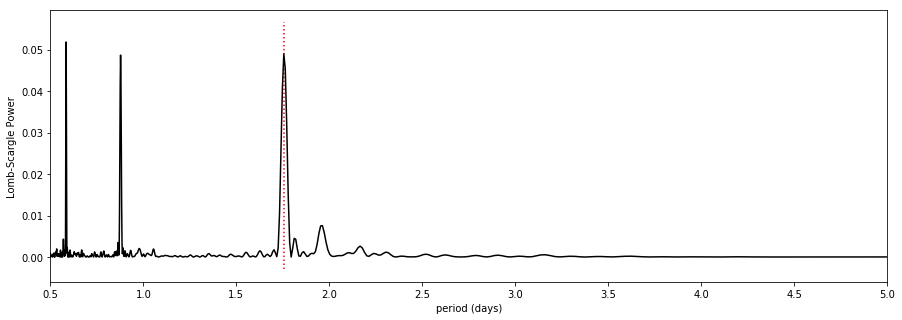

In [30]:
#get positive periods
idx1 = periods > 1
#
idx2 = np.argmax(power[idx1])
peak = periods[idx1][idx2]

fig, ax = pl.subplots(1,1,figsize=(15,5))
ax.plot(periods, power, 'k-')
ax.set(xlim=(0.5, 5),
#         , ylim=(0, 0.01),
   xlabel='period (days)',
   ylabel='Lomb-Scargle Power')
ax.vlines(peak, *ax.get_ylim(), linestyles='dotted', colors='r')

print(peak)

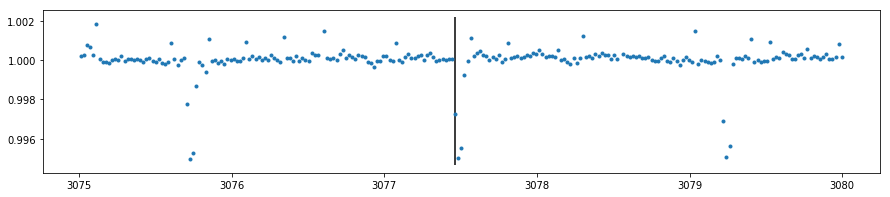

In [15]:
idx = (3075 < t) & (t < 3080)
tsub, fsub = t[idx], f_d[idx]
idx = fsub < np.median(fsub) - 0.5 * np.std(fsub)
t0 = np.median(tsub[idx])

fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(tsub, fsub, '.')
ax.vlines(t0, *ax.get_ylim())

In [16]:
#import simfit
#tf, ff = simfit.util.fold(t, f, peak, t0)

def get_tns(t, p, t0):

    idx = t != 0
    t = t[idx]

    while t0-p > t.min():
        t0 -= p
    if t0 < t.min():
        t0 += p

    tns = [t0+p*i for i in range(int((t.max()-t0)/p+1))]

    while tns[-1] > t.max():
        tns.pop()

    while tns[0] < t.min():
        tns = tns[1:]

    return tns

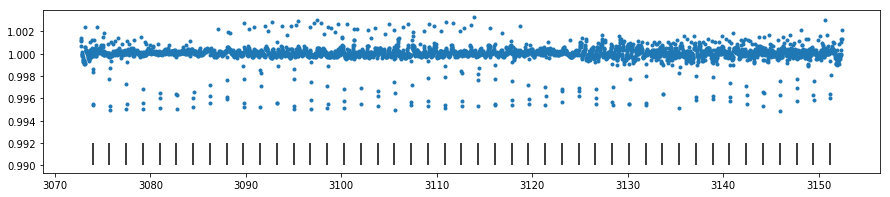

In [17]:
tns=get_tns(t, peak, t0)

fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(t, f_d, '.')
ax.vlines(tns, 0.99, 0.992)

## Fold

In [18]:
def fold(t, f, p, t0, width=0.4, clip=False, bl=False, t14=0.2):
    tns = get_tns(t, p, t0)
    tf, ff = np.empty(0), np.empty(0)
    for i,tn in enumerate(tns):
        idx = (t > tn - width/2.) & (t < tn + width/2.)
        ti = t[idx]-tn
        fi = f[idx]
        fi /= np.nanmedian(fi)
        if bl:
            idx = (ti < -t14/2.) | (ti > t14/2.)
            assert np.isfinite(ti[idx]).all() & np.isfinite(fi[idx]).all()
            assert idx.sum() > 0
            try:
                res = sm.RLM(fi[idx], sm.add_constant(ti[idx])).fit()
                if np.abs(res.params[1]) > 1e-2:
                    print('bad data probably causing poor fit')
                    print('transit {} baseline params: {}'.format(i, res.params))
                    continue
                model = res.params[0] + res.params[1] * ti
                fi = fi - model + 1
            except:
                print("error computing baseline for transit {}".format(i))
                print("num. points: {}".format(idx.sum()))
                print(ti)
        tf = np.append(tf, ti)
        ff = np.append(ff, fi / np.nanmedian(fi))
    idx = np.argsort(tf)
    tf = tf[idx]
    ff = ff[idx]
    if clip:
        fc = sigma_clip(ff, sigma_lower=10, sigma_upper=2)
        tf, ff = tf[~fc.mask], ff[~fc.mask]
    return tf, ff

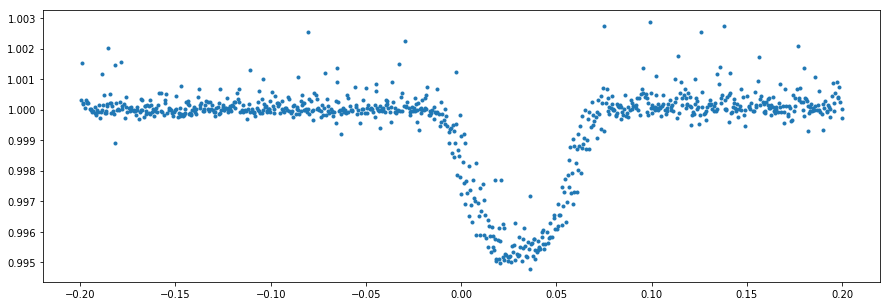

In [19]:
tf1, ff1 = fold(t, f_d, peak, t0)
fig, ax = pl.subplots(1,1,figsize=(15,5))
ax.plot(tf1, ff1, '.')

In [20]:
from pytransit import MandelAgol

MA = MandelAgol()

def model(theta, t):
    
    k,t0,p,a,i,u1,u2,_,_,_,_,_ = theta
    model = MA.evaluate(t, k, (u1,u2), t0, p, a, i)
    
    return model

def model_s(theta, x, y, t):
    offset = np.ones(len(t))
    s = (np.array(theta)*np.c_[x, y, x*y, x**2, y**2, offset, t]).sum(axis=1)
    return s

def baseline(theta, t):
    ti = t - t.mean()
    c0,c1,c2,c3 = theta[-4:]
    return c0 + c1 * ti + c2 * ti**2 + c3 * ti**3
    
    
def lnlike(theta, t, f):
    k,t0,p,a,i,u1,u2,sig,c0,c1,c2,c3 = theta
    m = model(theta, t) + baseline(theta, t)
    resid = f - m
    inv_sigma2 = 1.0/(sig**2)

    return -0.5*(np.sum((resid)**2*inv_sigma2 - np.log(inv_sigma2)))


def lnprob(theta, t, f):
    if t[0] > theta[1] > t[-1]:
        return -np.inf
    
    if np.any(theta[:-4] < 0):
        #coeffs
        return -np.inf
    if theta[4] > np.pi/2.:
        #inclination
        return -np.inf

    ll = lnlike(theta, t, f)
    return ll if np.isfinite(ll) else -np.inf


def scaled_a(p, t14, k, i=np.pi/2.):
    numer = np.sqrt( (k + 1) ** 2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

In [33]:
p=1.7555
t0=3074

p=peak

t14 = 0.1
k = np.sqrt(1-0.985)
i = np.pi/2.
a = scaled_a(p, t14, k, i)
u1, u2 = 0.2, 0.2
sig = f.std()
# lna = 1e-1
# lntau = 1
initial = [k,t0,p,a,i,u1,u2,sig,0,0,0,0]
args = (t, f)

nlp = lambda *args: -lnprob(*args)

import scipy.optimize as op

opt = op.minimize(nlp, initial, args=args, method='powell')
print(opt.success)
print(opt.x)

True
[  7.76575875e+00   3.08174427e+03   9.44614744e+00   2.42416088e+01
   5.88017270e-01   1.05517158e+01   1.05517158e+01   6.02012479e+03
   6.82902473e+06   4.79232335e+00   1.08001366e-02  -3.11898332e-03]


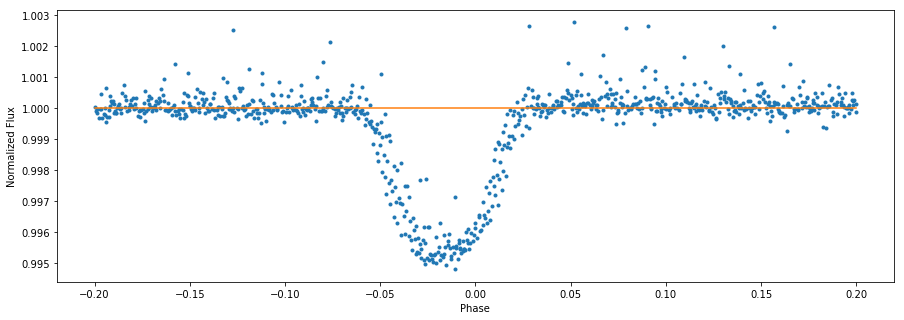

In [40]:
#t0, p = opt.x[1], opt.x[2]

tf, ff = fold(t, f, p, t0)
ff /= np.median(ff)

fig, ax = pl.subplots(1,1,figsize=(15,5))
ax.plot(tf, ff, '.')

m = model(opt.x, t)
t_fold,f_fold=fold(t,m,p,t0)

ax.plot(t_fold, f_fold)
pl.xlabel('Phase')
pl.ylabel('Normalized Flux')